<img src='../00_common/figures/iaeaheader.svg' style='width:100%'/>
<p style="font-size:2em;padding-bottom: 0.5em; font-weight: bold;">
<em>E-learning course on <br / ><br / >
Advanced Neutron Imaging</em>
</p> 

# Basic segmentation

Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2022

<img src='../00_common/figures/by-nc-nd.svg' style='height:30px'/>

## Introduction 
In many analysis applications it is needed to identify different regions of the image. This tutorial will show how you can do this with help of tresholds.

### What you will learn

### Required knowledge
This tutorial needs the previous image processing tutorials in this e-learning section
- Introduction to images
- Noise 
- Filters


### We need some packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tifffile as tiff
import skimage.filters as flt
import skimage.morphology as morph
from scipy.ndimage import convolve
import sys

if "google.colab" in sys.modules:
    # Running on colab we need to download repos from github
    !rm -rf scripts
    !rm -rf ImageProcessing
    !git clone https://github.com/ImagingELearning/ImageProcessing.git
    !git clone https://github.com/neutronimaging/scripts.git
    data_path="/content/ImageProcessing/tutorials/00_common/data/"
    %pushd .
    %cd /content/ImageProcessing/tutorials/00_common/data
    !unzip beads.zip
    %popd
    sys.path.append("/content/scripts/python/")
    sys.path.append("/content/ImageProcessing/tutorials/00_common/")
else: 
    # Running locally on your computer
    data_path = "../00_common/data/"
    sys.path.append('../00_common/')

import readers as rd
import plotsupport as ps

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


## Revisiting the histogram

### Test images and their histograms

### The bi-level image
The first image is a bi-level image. It has the advantage that we can modify it by adding noise and blurring to mimic a real image and still have a ground truth to compare the segmentation performance with.

It is a 3D image and as you can see in the histogram we only have two levels in this image.

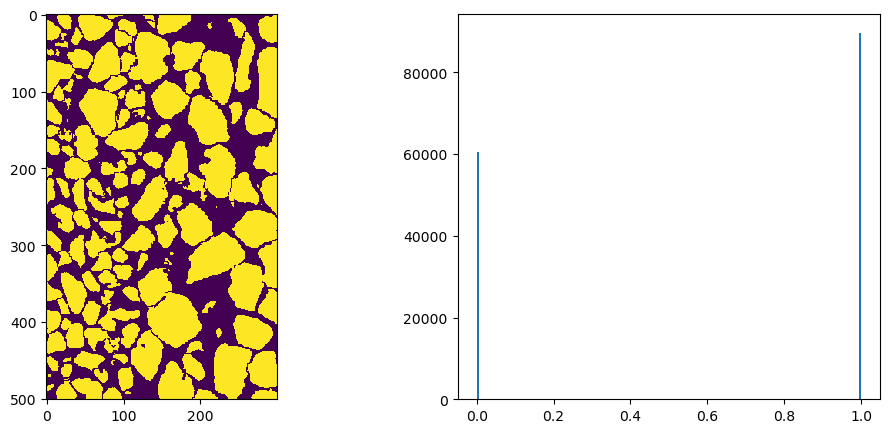

In [35]:
img=np.load(data_path+'grains.npy')

img=img[img.shape[0]//2]
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].imshow(img,interpolation='none')
ax[1].hist(img.ravel(),bins=200);

### Noisy images
For the noisy images we add Gaussian noise with two different $\sigma$

In [36]:
s=[0.1,0.3,0.5]
n1=img + np.random.normal(0,s[0],size=img.shape)
n2=img + np.random.normal(0,s[1],size=img.shape)
n3=img + np.random.normal(0,s[2],size=img.shape)

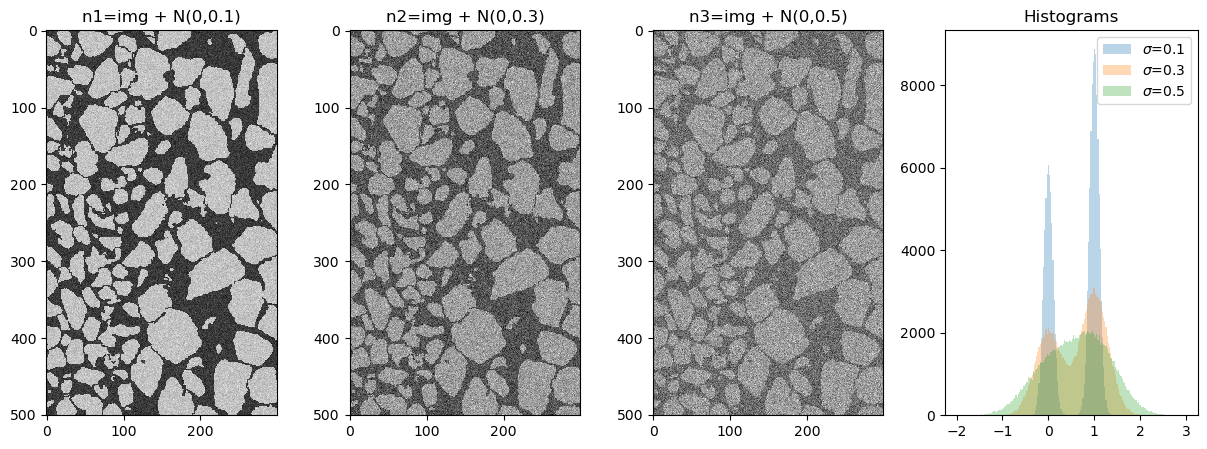

In [37]:
# Visualization
fig,ax = plt.subplots(1,4,figsize=(15,5))

ax[0].imshow(n1,interpolation='none',cmap='gray')
ax[0].set_title(r'n1=img + N(0,{0})'.format(s[0]))

ax[1].imshow(n2,interpolation='none',cmap='gray');
ax[1].set_title(r'n2=img + N(0,{0})'.format(s[1]));
ax[2].imshow(n3,interpolation='none',cmap='gray');
ax[2].set_title(r'n3=img + N(0,{0})'.format(s[2]));

bins=np.linspace(-2,3,200)
ax[3].hist(n1.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[0]))
ax[3].hist(n2.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[1]))
ax[3].hist(n3.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[2]))
ax[3].legend()
ax[3].set_title('Histograms');

As you can see here, the two peaks in the histograms overlap more for lower signal to noise ratio. This is a fact that make life harder when you try to segment the images.

## Thresholding
Thresholding is a technique to segment images by comparing the pixel values to a constant, $\gamma$, and assign the class of the pixel depending on whether it is less or greater than the constant value.

$$b(x)=\begin{cases}0&img(x)<\gamma\\
    1&\gamma\leq img(x)\end{cases} \forall x \in \Omega_{img}$$

_i.e._ basic thresholding is a pixel wise operation. Below, we will look at some techniques to find the threshold.

### Manual tresholding using the histogram
With manual threshoding, you decide where to put the threshold. This decision is mostly guided by inspecting the histogram. The logic choise is to place it in the middle between the two peaks in the histogram. Let's try this on our three test images.

We will also use manual thresholds to better understand the consequences of setting the threshold to different values within the graylevel distribution.

In [38]:
gamma = 0.5
b1    = gamma<=n1
b2    = gamma<=n2
b3    = gamma<=n3

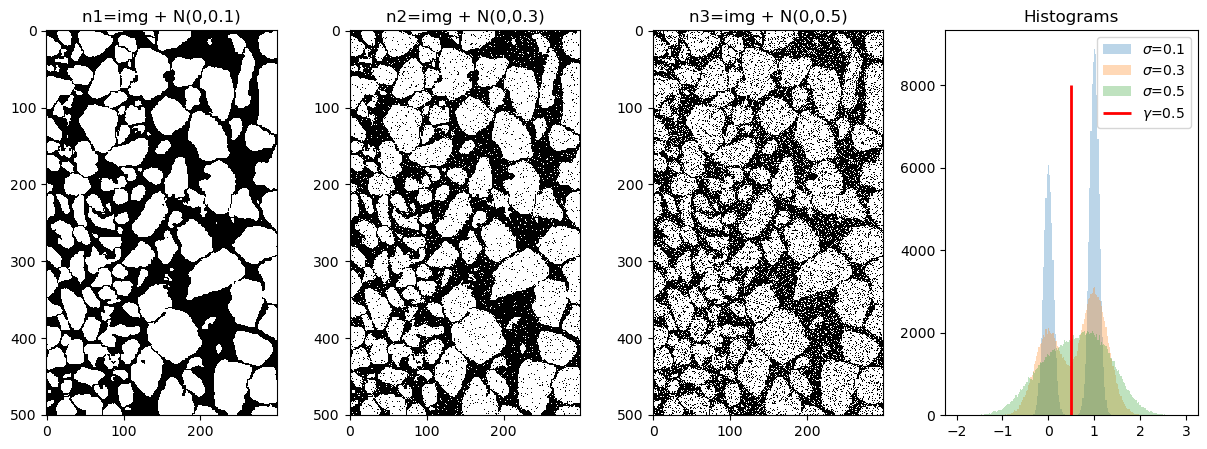

In [39]:
# Visualization
fig,ax = plt.subplots(1,4,figsize=(15,5))

ax[0].imshow(b1,interpolation='none',cmap='gray')
ax[0].set_title(r'n1=img + N(0,{0})'.format(s[0]))

ax[1].imshow(b2,interpolation='none',cmap='gray');
ax[1].set_title(r'n2=img + N(0,{0})'.format(s[1]));
ax[2].imshow(b3,interpolation='none',cmap='gray');
ax[2].set_title(r'n3=img + N(0,{0})'.format(s[2]));

bins=np.linspace(-2,3,200)
ax[3].hist(n1.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[0]))
ax[3].hist(n2.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[1]))
ax[3].hist(n3.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[2]))
ax[3].vlines([gamma],ymin=0,ymax=8000,label='$\gamma$={0}'.format(gamma),lw=2,color='r')
ax[3].legend()
ax[3].set_title('Histograms');

In this example you can see that the thresholding doesn't provide that good result for images _n2_ and _n3_. The reason is that the noise distributions overlap between the two classes. This has the consequence that we incorrectly assign some pixels as background and foreground respectively. 

Now let's see what happens when move the threshold level to different values, e.g. $\gamma$={0.0,0.25, 0.75, 1.0} in the three test images _n1_, _n2_, and _n3_. 

Here we apply the threshold as

$$\gamma \leq image$$

Which results in white areas for pixel values strictly greater than the threshold.

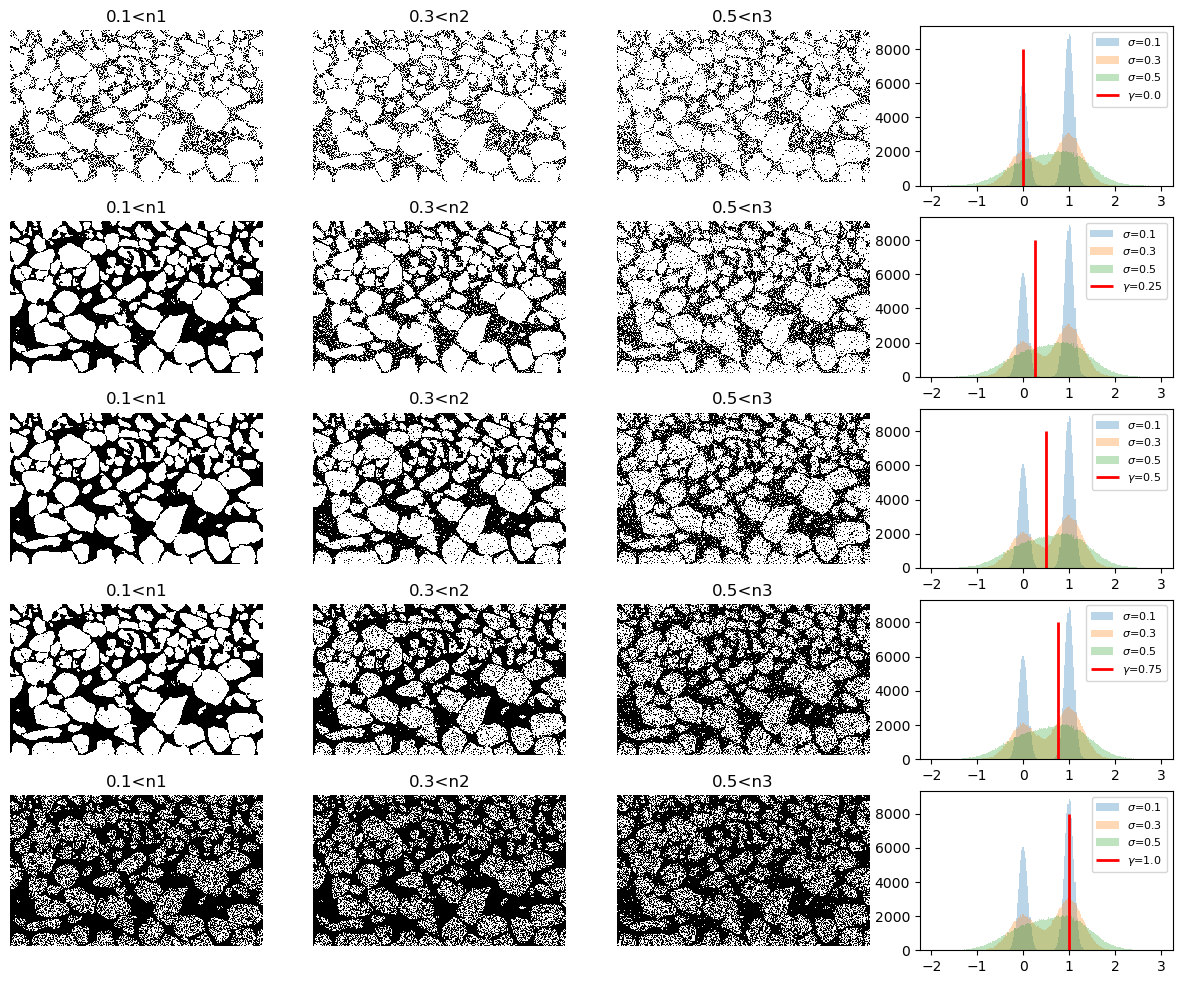

In [40]:
gamma = [0.0, 0.25, 0.5 ,0.75, 1.0]

# We need a matrix of plot panels for the visualization
fig,axes = plt.subplots(len(gamma),4,figsize=(15,12))

for ax,gamma in zip(axes,gamma) :
    # Thresholding using new gamma
    b1    = gamma<=n1
    b2    = gamma<=n2
    b3    = gamma<=n3
    
    # Show the result
    ax[0].imshow(b1.transpose(),interpolation='none',cmap='gray')
    ax[0].set_title(r'{0}<n1'.format(s[0]))
    ax[0].axis('off')
    ax[1].imshow(b2.transpose(),interpolation='none',cmap='gray');
    ax[1].set_title(r'{0}<n2'.format(s[1]));
    ax[1].axis('off')
    ax[2].imshow(b3.transpose(),interpolation='none',cmap='gray');
    ax[2].set_title(r'{0}<n3'.format(s[2]));
    ax[2].axis('off')
    
    bins=np.linspace(-2,3,200)
    ax[3].hist(n1.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[0]))
    ax[3].hist(n2.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[1]))
    ax[3].hist(n3.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[2]))
    ax[3].vlines([gamma],ymin=0,ymax=8000,label='$\gamma$={0}'.format(gamma),lw=2,color='r')
    ax[3].legend(fontsize=8);

In this example you see that the number of misclassified pixels increase when you are closer to one of the modes and that the class with more remote distribution will be better classified. Take a look at the last row where the threshold is set to $\gamma=1$, i.e., in the middle of the grain distribution. Here the grains are badly segmentated but the background with its distribution centered around 0 is almost perfect segmented.

## Thresholding at low SNR

### Overlapping classes
A low SNR is not a problem as long as you have a high-contrast image. In this case, the histogram modes will be well separated and it is easy to place the threshold as you have seen previously. This is usually not the case and the noise distribution of the classes will overlap.

In [ ]:
classA = np.random.normal(-1,1,size=10000);
classB = np.random.normal(1,1,size=10000);

plt.hist(classA,bins=150,alpha=0.5);
plt.hist(classB,bins=150,alpha=0.5);

bbox_props = dict(boxstyle="larrow", fc='lightgreen', ec="g", lw=2)
t = plt.text(0.8, 70, "Class overlap", ha="left", va="center", rotation=30,
            size=15,
            bbox=bbox_props)


The class choice in the interval of overlapping classes is ambiguous and results in a number of missclassified pixels. How many and how they are misclassiffied depends on the position of the threshold.

### Misclassified pixels
We just saw that the class overlap causes misclassified pixels. Now we will look into more detail what this means.

Let's first define some nomenclature to describe segmentation outcome:
Ideally we the pixels to be correctly assigned
$$
\begin{cases}
\mathbf{TP} & \mbox{True positive} &  \mbox{The pixel is correctly assigned the foreground class}\\
\mathbf{TN} & \mbox{True negative} &  \mbox{The pixel is correctly assigned the background class}\\
\end{cases}
$$

Then we have the misclassifications
$$
\begin{cases}
\mathbf{FP} & \mbox{False positive} &  \mbox{The pixel is background, but was assigned the foreground class}\\
\mathbf{FN} & \mbox{False negative} &  \mbox{The pixel is foreground, but was assigned the background class}\\
\end{cases}
$$

This can be demonstrated with the histograms below


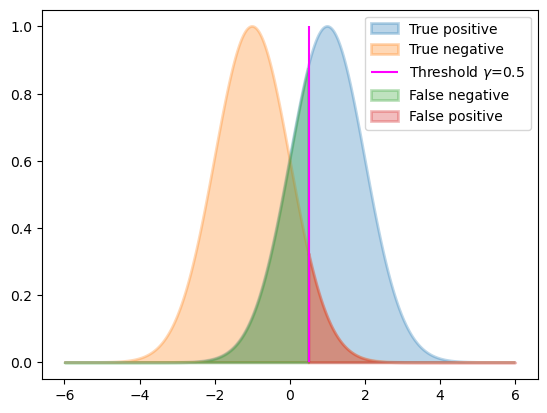

In [41]:
x=np.linspace(-6,6,1000)
h0 = np.exp(-(x-1)**2/2)
h1 = np.exp(-(x+1)**2/2)

gamma=0.5

# Visualization
gidx = np.abs(x - gamma).argmin()
plt.fill(x,h0,label='True positive',alpha=0.3,ec=colors[0],lw=2)
plt.fill(x,h1,label='True negative',alpha=0.3,ec=colors[1],lw=2)

plt.vlines([x[gidx]],ymin=0,ymax=1,color='magenta',label='Threshold $\gamma$={0}'.format(gamma))

plt.fill_between(x[:gidx],0,h0[:gidx],color=colors[2],label='False negative',alpha=0.3,ec=colors[2],lw=2)
plt.fill_between(x[gidx:],0,h1[gidx:],color=colors[3],label='False positive',alpha=0.3,ec=colors[3],lw=2)

plt.legend();

In this example, you see that the probability to misclassify pixels very much depends on the position of the threshold.

Now, let's take a look at our examples with the grains above;


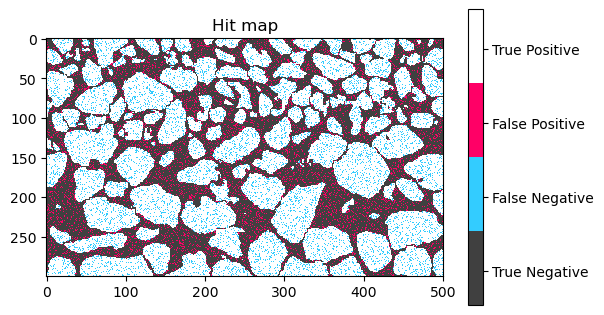

In [42]:
ps.showHitMap(np.transpose(img),0.5<np.transpose(n3))

With this visualization, we see that a lot of the pixels are actually misclassified both as false positives and negatives. This is still a qualitative assessment and in the next section we will look more in detail into how the segmentation performance can be quantified.

### Measuring the segmentation performance

#### A ground truth is needed
The first step before we can measure the segmentation performace is that we need to know what the truth is. This is a bit missing the purpose of applying a segmentation method in the first place; if we have the truth we need to apply any segmentation anymore. The idea is however that you produce a ground truth based on a small fraction of your data that you use to demonstrate the performance and then once you have show that your method is reliable it is time to use the method on the full data set.

There are different ways to obtain a ground truth:
1. Manually segment a fraction of your experiment data to the best of your ability.
2. Simulate data that have similar characteristics as the experiment data. This is what we have done already in this tutorial.

The first may be quite labour intense but is more likely to correspond to real use case, while the second is easy to generate a lot of test examples for better statistics and more variations. So, in the end it makes sense to use a mix of the two approches to better understand the segmenation performance.


#### Counting hits and misses - the confusion matrix

Quantifying the performacance of a segmentation method is done by comparing the segmented image to with its ground truth. In this comparison you count the number of pixel that are equal to the expected classes or which type of misclassification occured. This can be visualized as four images:

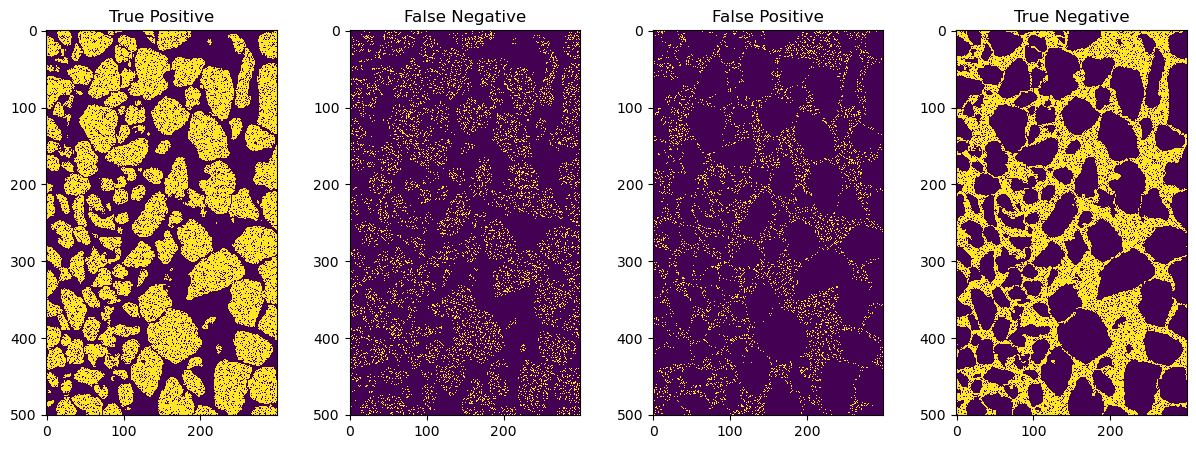

In [43]:
ps.showHitCases(img,0.5<n3)

When we count the number of pixels in each of the images above we can get either the abslute number to describe the segmentation performance. Mostly, it is however more relevant to compute percentages instead. A popular way to present the result is to use a confusion matrix. 

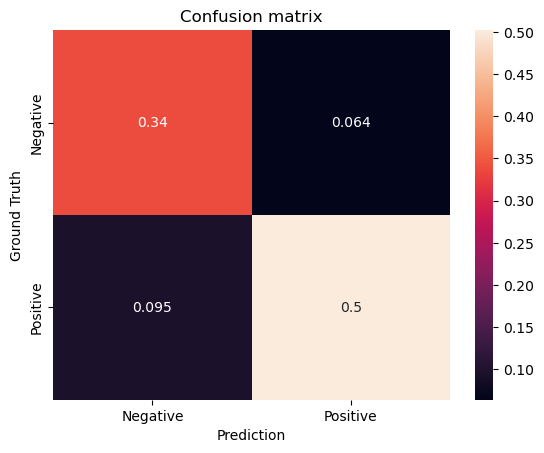

In [12]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

cmat = confusion_matrix(img.ravel(), (gamma<n3).ravel(), normalize='all')
heatmap(cmat, annot=True); 

plt.title('Confusion matrix');
plt.gca().set_xticklabels(['Negative','Positive']);
plt.gca().set_yticklabels(['Negative','Positive']);
plt.ylabel('Ground Truth')
plt.xlabel('Prediction');

With the confusion matrix we can see the fraction of correct classifications along the main diagonal and the misclassifications left and right of the diagonal. The confusion matrix grows with the number of classes. 

The confusion matrix only shows the performance in scalars, but is not able to tell if the error is randomly distributed or spatially depending on for example the proximity of edges. 

Therefore, it makes sense to show the confusion matrix together with a hit-miss map like the one above. 


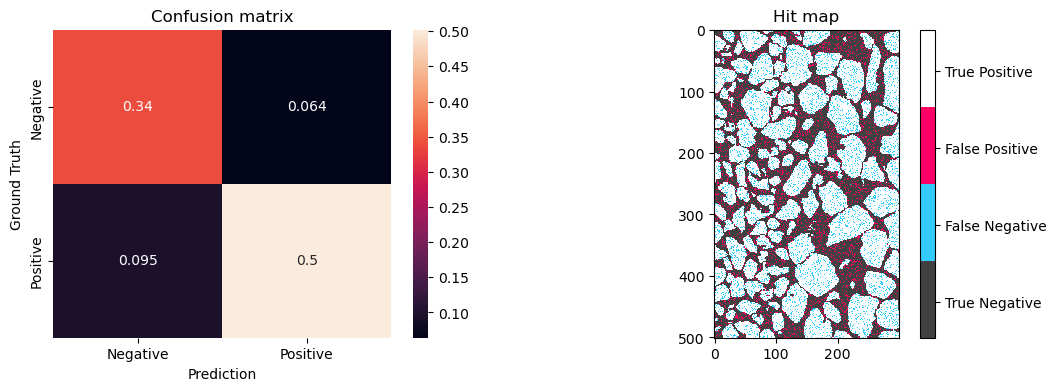

In [13]:
ps.showHitConfusion(img,0.5<n3)

In this example, we can see that there is no or little spatial correlation with the image items and the misclassifications.

## Algorithms to find the threshold

Next step is to use algorithms to find the threshold for us. This has the advantage that the result is reproducible for data with the same noise distribution and not left the arbitrary decision of the person who analyses the images. 


### Intermode threshold

Intermode thresholds are based on the concept of finding the peaks of two classes and selecting the threshold as the average of their positions.

$\gamma=\frac{Peak_{high}+Peak_{low}}{2}$

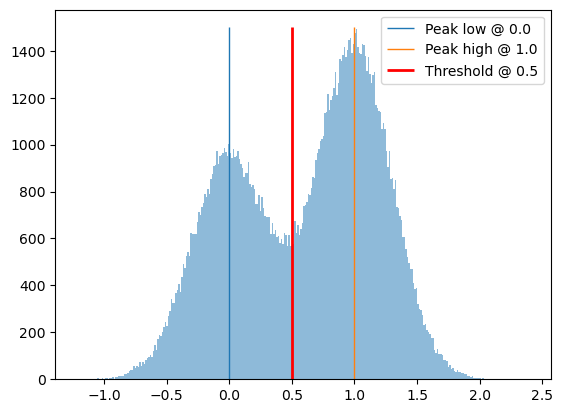

In [14]:
plt.hist(n2.ravel(), bins=300,alpha=0.5);
plt.vlines([0],ymin=0,ymax=1500,color=colors[0],lw=1,label='Peak low @ 0.0')
plt.vlines([1],ymin=0,ymax=1500,color=colors[1],lw=1,label='Peak high @ 1.0')
plt.vlines([0.5],ymin=0,ymax=1500,color='r',lw=2,label='Threshold @ 0.5')
plt.legend();

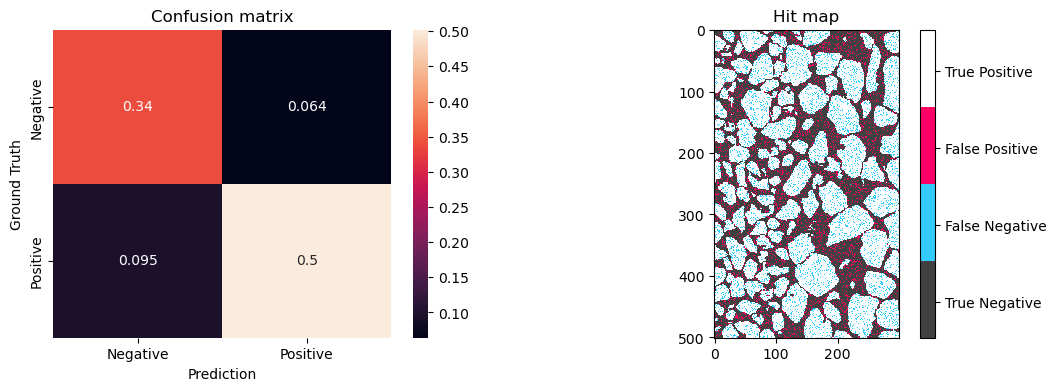

In [15]:
mode0 = 0 
mode1 = 1

th = (mode1+mode0)/2

b1 = th<n3
ps.showHitConfusion(img,b1)

### Otsu threshold
The method described by [Otsu in 1978](https://en.wikipedia.org/wiki/Otsu%27s_method) is probably the most used histogram-based thresholding method. It is based on the concept of minimizing the variance of each class and maximizing the variance between the classes. This produces a cost function that provides the optimal threshold at its maximum. The threshold is generally placed between the main modes of the two classes. Otsu also describes an extension to multiple classes. 

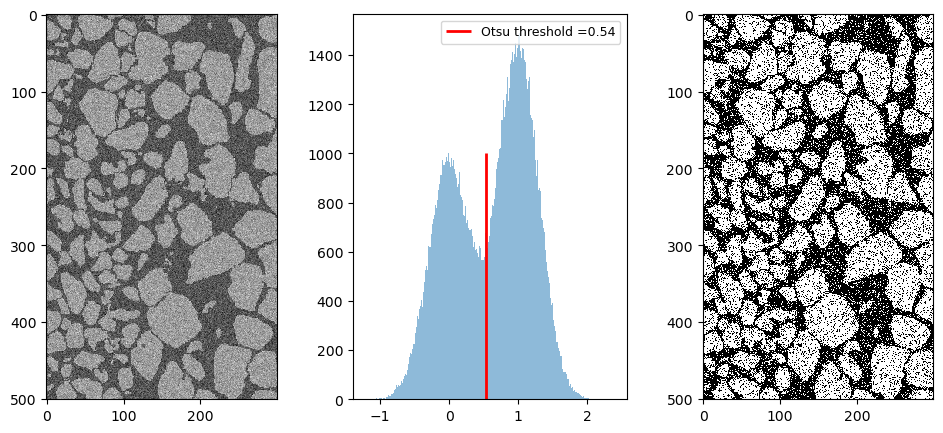

In [16]:
otsu=flt.threshold_otsu(n3.ravel())

#Apply the threshold
b   = otsu<n3

# Visualization
fig,ax=plt.subplots(1,3,figsize=(12,5))
ax[0].imshow(n2,interpolation='none',cmap='gray')
ax[1].hist(n2.ravel(),bins=300,alpha=0.5);
ax[2].imshow(b,interpolation='none',cmap='gray')
ax[1].vlines([otsu],ymin=0,ymax=1000,color='red',lw=2,label='Otsu threshold ={0:0.2f}'.format(otsu))
ax[1].legend(fontsize=9);

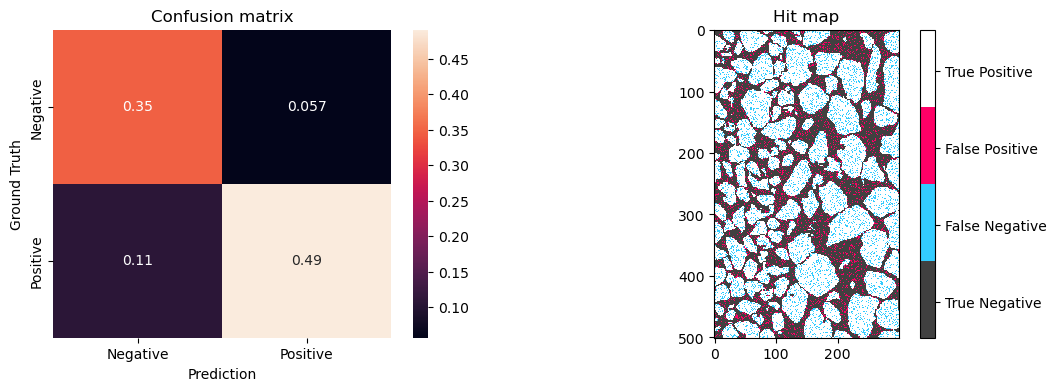

In [17]:
ps.showHitConfusion(img,b)

### Triangle threshold
The triangle threshold is designed to segment images where the target information is located in the distribution tail. This is in particular relevant for cases of class imbalance and still good contrast between the two classes. 
The example below demonstrated on an edge detection example. In the example we use the grain image and apply a Sobel filter. Edges are typically represented by only a few percent of the image and the histogram has a single main mode for the image bulk with a long tail containing the edge pixels. 

The threshold is determined by drawing a line between the histogram maximum and the end of the tail. Next step is to probe the perpendicular distance between the line and the histogram plot. The threshold is chosen for the greatest distance.

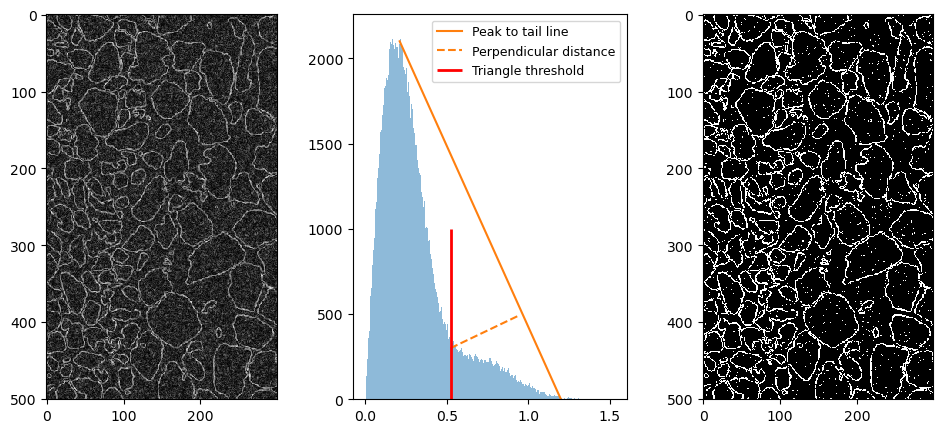

In [18]:
# Enhance the edges
e2  = flt.sobel(n2)

# Find the threshold
tri = flt.threshold_triangle(e2.ravel())

#Apply the threshold
b   = tri<e2

# Visualization
fig,ax=plt.subplots(1,3,figsize=(12,5))
ax[0].imshow(e2,interpolation='none',cmap='gray')
ax[1].hist(e2.ravel(),bins=300,alpha=0.5);
ax[2].imshow(b,interpolation='none',cmap='gray')
ax[1].plot([0.21,1.2],[2100,0],c=colors[1],label='Peak to tail line')
ax[1].plot([tri,0.95],[300,495],'--',c=colors[1],label='Perpendicular distance')
ax[1].vlines([tri],ymin=0,ymax=1000,color='red',lw=2,label='Triangle threshold')
ax[1].legend(fontsize=9);

### Threshold with hysteresis

A method to reduce the number of false negatives is to use a method called threshold with hysteresis. This method uses two thresholds. One that is set to under-segment the image and the other to over-segment the it. The two images are combined by performing a region growing process that grows the under-segmented regions until they reach the bondary of the over-segmented regions. In this way, only over-segmented regions that include under-segmented regions will remain in the final image. This means that misclassified pixels in the background will be discarded.

In the example below we explore the threshold with hysteresis on our $n_2$ image.

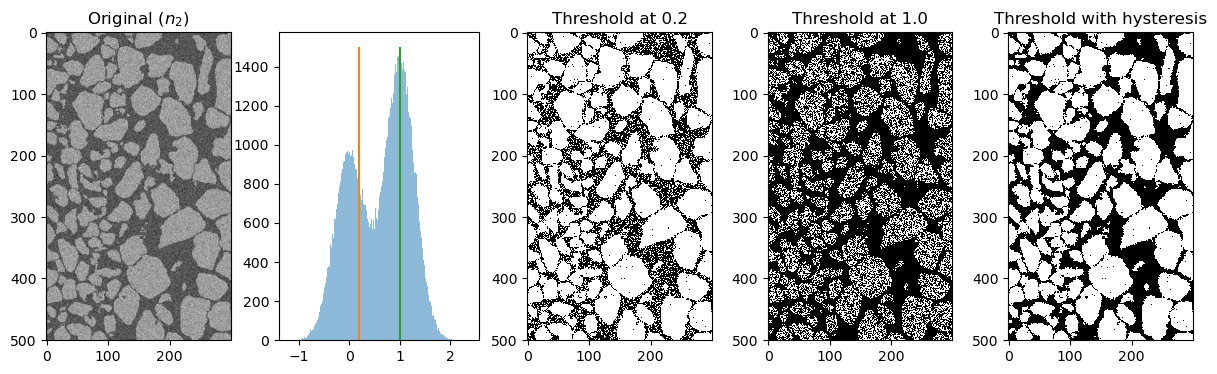

In [19]:
th_low  = 0.2
th_high = 1

b_low   = th_low  < n2
b_high  = th_high < n2
b       = flt.apply_hysteresis_threshold(n2, th_low, th_high)

# Visualization
fig, ax = plt.subplots(1,5,figsize=[15,4])
ax[0].imshow(n2,cmap='gray')
ax[0].set_title('Original ($n_2$)')
ax[1].hist(n2.ravel(),bins=300,alpha=0.5);
ax[1].vlines([th_low,th_high],ymin=0, ymax=1500, colors = colors[1:])

ax[2].imshow(b_low,cmap='gray', interpolation='none');
ax[2].set_title('Threshold at {0:0.1f}'.format(th_low));
ax[3].imshow(b_high,cmap='gray', interpolation='none');
ax[3].set_title('Threshold at {0:0.1f}'.format(th_high));
ax[4].imshow(b,cmap='gray', interpolation='none')
ax[4].set_title('Threshold with hysteresis');

The result looks very good. We have almost no misclassifications compared to the image that were segmented using a single threshold. Now we can verify our result using the result using the confusion matrix and hit-map.

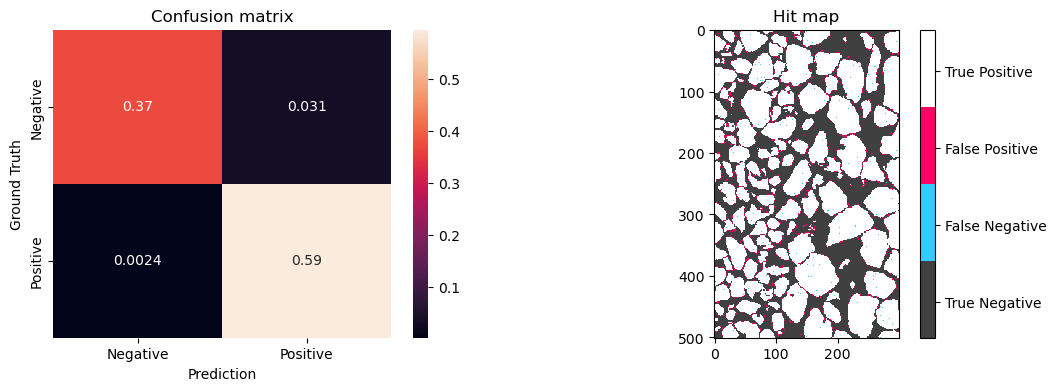

In [20]:
ps.showHitConfusion(img,b)

The confusion matrix confirms a radical improvement. It must however be noted that the misclassifications now a located near the edges of the items in the image. This is something to pay attention to and possibly improve by using a different threshold pair for the segmentation.

Let's try some pairs to see how the segmenation performance is affected

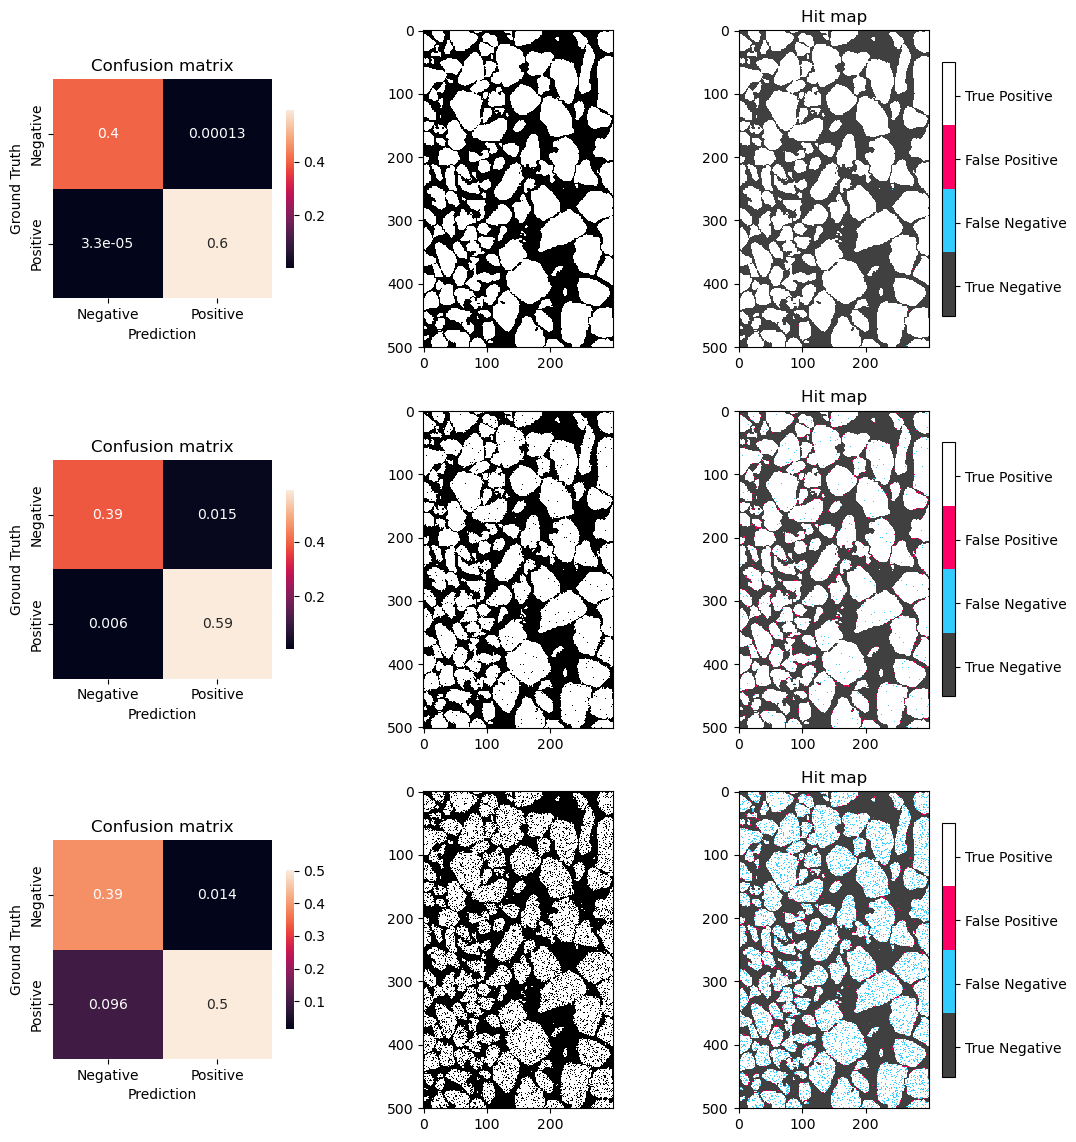

In [22]:
low  = [0.3,0.3,0.5]
high = [1,1,1.5]
imgs = [n1,n2,n3]
fig,axes = plt.subplots(3,3,figsize=(12,14))
for ax,n,th_low,th_high in zip(axes,imgs,low,high) :
    b=flt.apply_hysteresis_threshold(n, th_low, th_high)
    ps.showConfusionMatrix(img,b,ax=ax[0])
    ax[0].set_aspect("equal")
    ax[1].imshow(b,interpolation='none',cmap='gray')
    ps.showHitMap(img,b,ax=ax[2])

The last case shows that thresholding with hysteresis is not always the solution. You have to guarantee that the items you want to keep, are fully included in the generous threshold. If not, you'll get the result in the last thresholding example - there will be holes in the segmented image.

## Morphological image processing
We have now seen that there may be quite many misclassified pixels in segmented images. This can be handled by improving the SNR of the image before as a post processing step after segmenation. Each has it benefits and often both methods are combined to obtain the best result.

Mophological image processing introduces a new set of filters. These are essentially based on the local min and max operations instead of weighted sums. 

### The fundamental operations

- Erosion - $\varepsilon_{SE}(f)$ - shrinks the object in the image by computing the local max of the neighborhood.
- Dilation - $\delta_{SE}(f)$ - grows the objects in the image by computing the local max of the neighborhood.

The structure element _SE_ describes which neighboodhood pixels to compare with. A 'one' means that the pixel is part of the neighborhood and a 'zero' is ignored.

First we need an image to test the $\varepsilon$ and $\delta$ operations on. In this case we build our own image as an array of ones and zeros. There are three regions in the image.

In [ ]:
f=np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,1,1,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,1,1,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
            [0,0,0,0,1,1,1,0,0,1,0,0,0,0,0],
            [0,0,0,0,1,1,1,0,1,1,0,0,0,0,0],
            [0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
            [0,0,0,0,0,1,1,1,1,0,0,0,0,0,0],
            [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,1,1,1,0,0,0],
            [0,0,0,0,0,0,0,0,0,1,1,1,1,0,0],
            [0,0,0,0,0,0,0,0,0,1,1,1,1,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

The operators have the subscript _SE_ whicch stands for structure element sometimes also called footprint. This is the pattern the operations use to compare the neighborhood around the current pixel. In this example, we will use two different SE's and compare the resulting images. The SE's both have the size 3$\times$3 and the box has all elements set to one while the cross has the corners replaced by zeros to form a cross.

We use the variable _se_ to select the SE in the next cell.

In [32]:
box   = np.ones([3,3])
cross = np.array([[0,1,0],
                 [1,1,1],
                 [0,1,0]])

se = box
# se = cross

Now we try erosion and dilation on test image $f$ and see what happens. 

In [ ]:
e = morph.erosion(f,se)
d = morph.dilation(f,se)

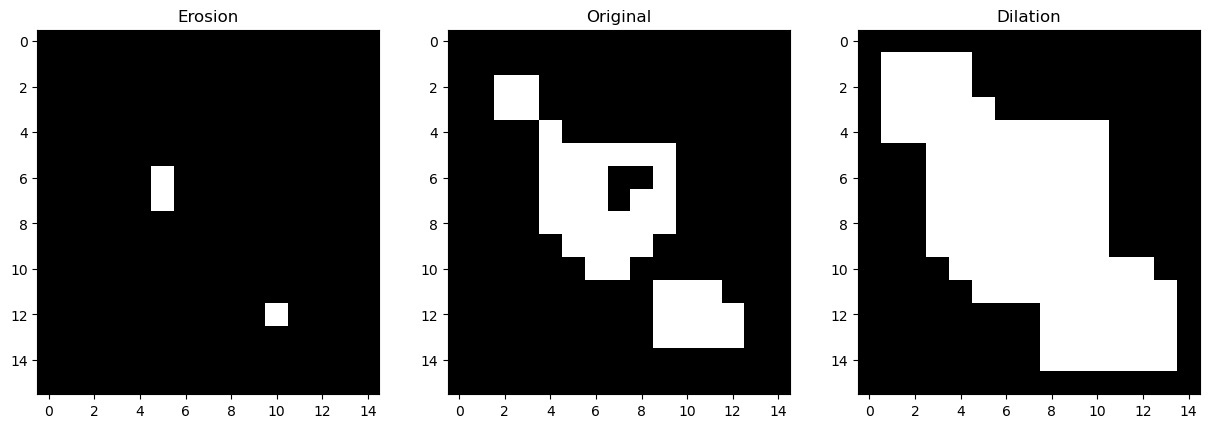

In [35]:
# Visualization only
fig,ax = plt.subplots(1,3,figsize=(15,5))
plt.imshow(f,interpolation='none',cmap='gray')

ax[0].imshow(e,interpolation='none',cmap='gray')
ax[0].set_title('Erosion')
ax[1].imshow(f,interpolation='none',cmap='gray')
ax[1].set_title('Original')
ax[2].imshow(d,interpolation='none',cmap='gray')
ax[2].set_title('Dilation');

Now change to the other SE and observe what happens. 

__Questions__
1. Which SE changes the item shapes more in the image?
2. Why is that so?

### Combined operations
It is mostly too drastic to apply a single morphologic operator. The object shapes change too much!

This can be handled by using a sequence of operations
- Opening - $\phi_{SE}(f) = \delta_{SE}(\varepsilon_{SE}(f))$
- Closing - $\gamma_{SE}(f) = \varepsilon_{SE}(\delta_{SE}(f))$

In the example below, we use opening and closing on the same image as above. Try the effect of different SE shapes by uncommenting the cross in the cell below.

In [ ]:
se = box
# se = cross

o = morph.opening(f,se)
c = morph.closing(f,se)

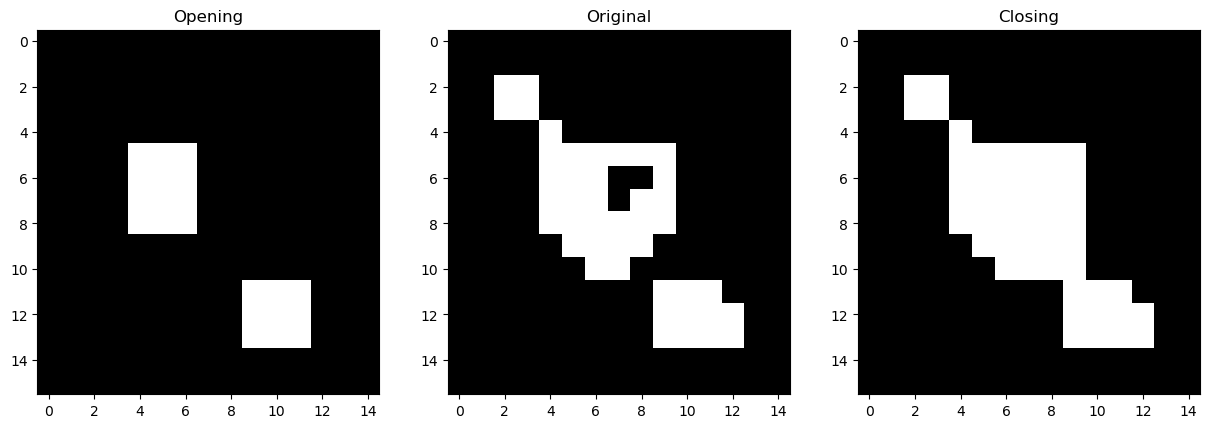

In [34]:
# Visualization only
fig,ax = plt.subplots(1,3,figsize=(15,5))
plt.imshow(f,interpolation='none',cmap='gray')

ax[0].imshow(o,interpolation='none',cmap='gray')
ax[0].set_title('Opening')
ax[1].imshow(f,interpolation='none',cmap='gray')
ax[1].set_title('Original')
ax[2].imshow(c,interpolation='none',cmap='gray')
ax[2].set_title('Closing');

### Using morphological operations to clean up segmented images
The examples above were only presented small image to demonstrate the morphological operators. The next step is to apply the operators on larger segmented images.

Let's take the $b=0.5<n_2$ image again and apply first erosion and dilation with SE=box(3,3)

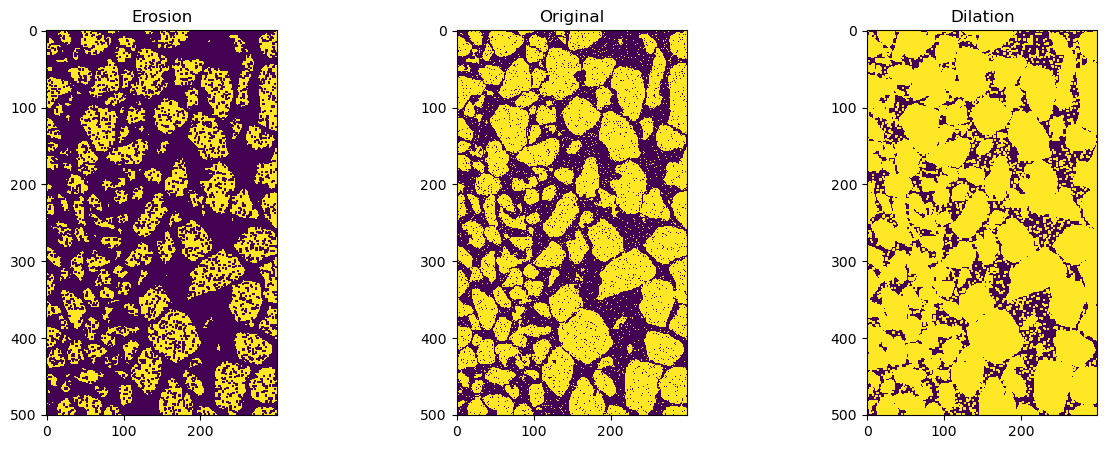

In [25]:
b  = 0.5<n2
se = np.ones([3,3])
e  = morph.erosion(b,footprint=se)
d  = morph.dilation(b,footprint=se)

# Visualization
fig,ax = plt.subplots(1,3,figsize=[15,5])

ax[0].imshow(e,interpolation='none')
ax[0].set_title('Erosion')
ax[1].imshow(b,interpolation='none')
ax[1].set_title('Original')
ax[2].imshow(d,interpolation='none')
ax[2].set_title('Dilation');

In this example, we can confirm that erosion and dilation either under- or over-compensate the misclassifications. Erosion cleans the pore space between the grains at the cost of very fragmented grains. The dilation fills the grains but now the misclassifications in the porespace are grown. This is to be expected from the previous demnstrations with the smaller test image. 

Now let's see how the opening and closing operators perform on the grain image with the same structure element.

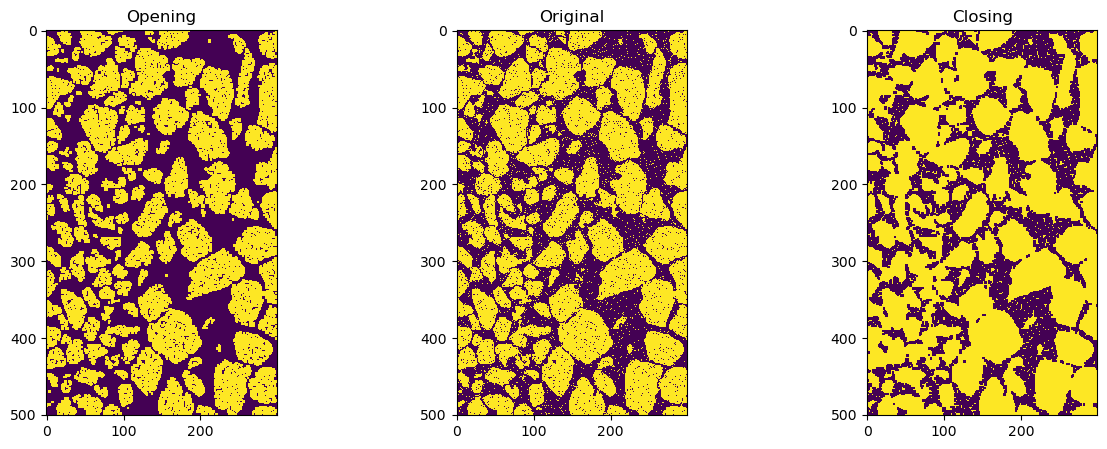

In [27]:
b  = 0.5<n2
se = np.ones([3,3])
o  = morph.opening(b,footprint=se)
c  = morph.closing(b,footprint=se)

# Visualization
fig,ax = plt.subplots(1,3,figsize=[15,5])

ax[0].imshow(o,interpolation='none')
ax[0].set_title('Opening')
ax[1].imshow(b,interpolation='none')
ax[1].set_title('Original')
ax[2].imshow(c,interpolation='none')
ax[2].set_title('Closing');

These operator perform better than the erosion and dilation; the pores or the grains are cleared and the losses are not that great. There are, however, still problem zones. These are in particluar when the grains are close or touching. Here, it could happen that items that were originally connected will be deteached and the other way around.

### The confusion matrix after opening and closing
Previously, the used the confusion matrix and the hit map to verify the performance of the segmentation. Let's now see the performance of opening and closing. First, we look at the thresholded image again for the comparison.

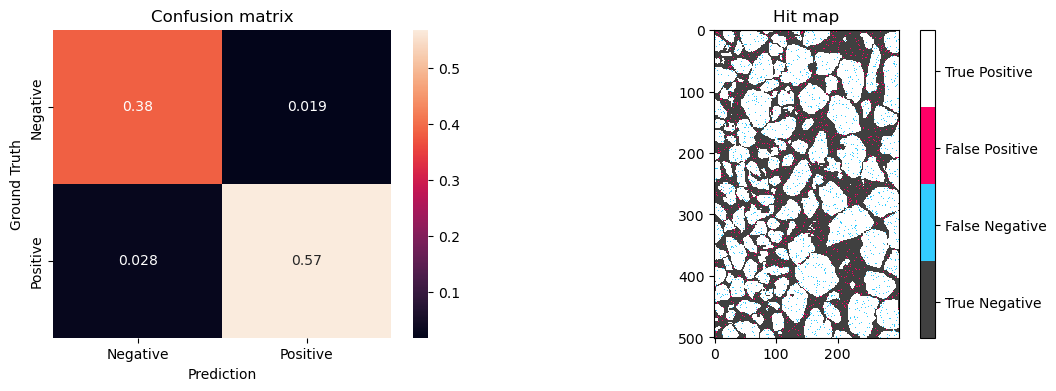

In [32]:
ps.showHitConfusion(img,b)

#### Opening

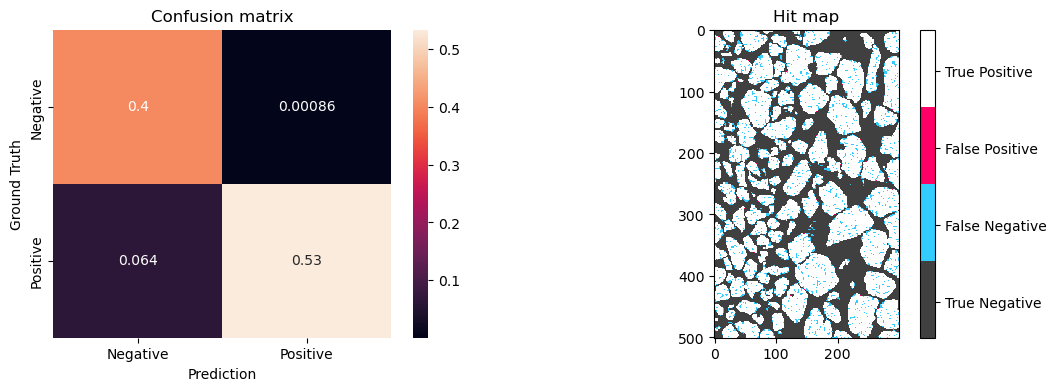

In [31]:
ps.showHitConfusion(img,o)

The opening radically reduces the false positives but the cost is an increase in false negatives which are located in the grains and possibly at touching points.

#### Closing

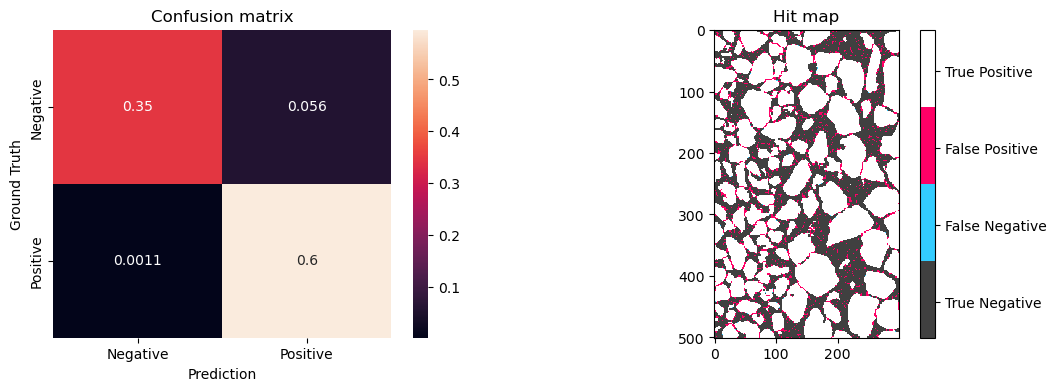

In [33]:
ps.showHitConfusion(img,c)

The closing reduces the false negatives but now the false positives have increased. In this example, it seems like many of the false positives are located near the item edges and also fill up thin separating gaps between the grains.

### Concluding remark for the morplogical operations
We have see that the morphological operations can be used to polish the segmenation from misclassified pixels. Often, it is necessary to apply a sequence of opening and closing to remove all misclassifications. This will have some impact on the resulting shapes and also on the following analysis. Therefore, it is important to reduce the structure element shape to a minimum. You can for example try to run the cells above with a cross-shaped structure element and see what that does to the cleaning performance.

It is also best if your segementation is of such high quality from the beginning that these operations are not needed. This can be achieved by first providing high SNR data, ideally already by having the opportunity to perform high SNR measurement, but the SNR can also be improved with different denoising filters. Finally, it is also good if you can use a segmentation approach that reduces the number of misclassified pixels.

## Summary

In this tutorial we learned
- How a bi-level image can be obtained using thresholds
- The threshold can be found using several algorithms. The choice depends on the characteristics of the data. 
- Thresholding often produces misclassified pixels.
- The confusion matrix can be used to visualize the degree of misclassifications if you have a ground truth image.
- Morphological opening and closing can be used to clean-up the thresholded images and reduce the number of misclassified pixels.